#### Irrigation system Model 


In [8]:
# imports 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import math


In [16]:
def reynolds_pipe(density, velocity, diameter, viscosity):
    """Calculate the Reynolds number for a given pipe flow.
        density:density of the fluid in [kg/m3]
        velocity:the mean velocity of the fluid in [m/s]
        viscosity:dynamic viscosity of the fluid in [Pa*s]
        diameter:inside diameter of the pipe in [m]
    """
    return density * velocity * diameter / viscosity


def friction_factor(Re, e, D):
    """ Calculate the friction for the Darcy-weisback formula
        Re: reynolds number 
        e: roughness factor 
        D: inner diameter of the pip
    """  
    
    if Re < 2000:   #Laminar flow
        f = 64/Re 
    if Re > 4000:   #Turbulent flow 
        f = 0.25/ (math.log10((e)/(3.7*D)+5.74/(Re**0.9)))**2
    else:  #Dunlop(1991) cubic interpolation formula for moody diagram
        R = Re/2000
        AB = 0.00328895476345399058690
        AA = -1.5634601348517065795
        Y2 = (e/(3.7*D)) + AB
        Y3 = -2 * math.log(Y2)
        FA = (Y3)**(-2)
        FB = FA * (2 - (AA * AB)/(Y2* Y3))
        X1 = 7* FA - FB
        X2 = 0.128 -17*FA +2.5*FB
        X3 = -0.128 + 13*FA -2*FB
        X4 = 0.032 - 3*FA +0.5*FB
        f = X1 + R*(X2 + R*(X3+R*X4)) 
    return f 

def pipe_head_losses(Q,D,L, e, rho = 1000, viscosity=10**(-3), g = 9.81):
    '''calculate the head losses of a pipe section
        Q: flow rate through pipe section 
        D: diameter of pipe section 
        e: rougness of pipesection 
        L:length of pipe section
        rho: density of fluid[kg/m3] --> default water 
        viscosity: viscosity of fluid [Pa.s] --> default water 
        g :gravitational acceleration [m/s2]
    '''
    v = Q / (math.pi * (D/2)**2)
    Re = reynolds_pipe(rho,v,D,viscosity)
    f = friction_factor(Re,e,D)
    return (f * L * v**2)/ (2*D*g) #Darcy-weisbach 

def minor_head_losses(k, Q, D, g = 9.81):
    '''calculate the head losses of each network component
        k: loss coeffient 
        Q: flow rate through minor loss section  
        D: diameter of pipe section 
        g :gravitational acceleration [m/s2]
    '''
    v = Q / (math.pi * (D/2)**2)
    return  k * (v**2)/ (2*g)


In [44]:
def network_head_losses(L_main, L_submain, L_lateral, n_lateral, n_plants_per_lateral, Q_total, n_emitters_per_plant =1):
    ''' Function that calculates the head loss of a drip irrigation network given the following inputs:
        L_main: the length of the main pipe (m)
        L_submain: the length of the submain pipe (m)  
        L_lateral: the length of each of the lateral pipes (m)
        n_lateral: the number of lateral pipes in the network --> should be even number 
        n_emitters_per_plant: number of drip emitters per plant, default = 1
        n_plants_per_lateral: number of plants per lateral, assumed to be evenly spaced 
        Q_total: total flow rate [m3/s]
        
    '''
    
    #water constants
    rho = 1000 #density of water[kg/m3]
    viscosity = 1.002**(-3) #dynamic viscosity of water [m3.s]
    g = 9.81 #gravitational acceleration [m/s2]

    #network components 
    n_tees = n_lateral-1 #number of t-joints in the network
    n_elbows = 2 #1 elbow connecting each of the end laterals 
    n_valve = 1 # at begining of network 
    n_emiiters_per_lateral = n_emitters_per_plant * n_plants_per_lateral
    D_main = 0.0442 #Inner diameter of main [m] --> sourced from Jordan example of (Development of a system model for low-cost, SOLAR-POWERED DRIP IRRIGATION SYSTEMS IN THE MENA REGION )
    D_submain = 0.0442#Inner diameter of submain [m]
    D_lateral = 0.0144 #Inner diameter of lateral [m]
    D_emitter = 0.0144 #diater of the emitter (1<D_later/D_emitter<1.2)
    Q_rated  = 0.002 #the rated flow rate of the drip irrigatiate [m3/h] --> ASSSUMED
    alpha = 0.116 * ((D_lateral/D_emitter)**13.87 -1) #emitter local loss coefficient from Provenzano et al. (2005) 

    #Q_total threshold test 
    Q_max = (Q_rated * n_emitters_per_plant * n_plants_per_lateral * n_lateral) / 3600
    if Q_total > Q_max:
        raise Exception(f"Sorry, the inputed flow rate is too large for the irrigation netork, Q_max = {Q_max}, Q_total = {Q_total} ")
    
    #Minor loss coeficients --> sourced from ...  
    k_tee_straight = 0.2 #use inlet velocity 
    k_tee_bend = 1
    k_elbow = 0.3
    k_valve = 10 #assumed to be a globe valve 
    k_contraction = 0.5 #assumed worsed case scenerio of maximum sudden contraction, use velocity of outgoing flow


    H_minor = 0 #Intitiate as 0  

    # mannings rougness coeficient  --> sourced from Demir et al (2009), assuming Polyethlene pipe 
    e_main = 0.005 * 10**(-3) #m
    e_submain = 0.005 * 10**(-3) #m
    e_lateral = 0.005 * 10**(-3) #m 


    #Losses in main 
    H_main = pipe_head_losses(Q_total,D_main,L_main, e_main)
    print(H_main)
    H_minor += minor_head_losses(k_valve, Q_total, D_main) # valve
    H_minor += 0.0120 * Q_total**1.5621 #AY40 filter from Demir et al. (2008) --> largest possible flow ranges 
    H_minor += 2*minor_head_losses(k_tee_bend, Q_total/2, D_main) # 2 branch tee flows to the submain
    H_minor += 2*minor_head_losses(k_contraction, Q_total/2, D_submain) #contraction from main to submain at outlet of tee (both sides) 

    #Losses in submain 
    submain_parts = int(n_lateral/2) #each side, so actually 2 times this value
    L_submain_parts = L_submain/(submain_parts*2 +1)
    H_submain = 0 #intiate as 0 
    for i in range(submain_parts):
        Q_part = ((Q_total/2)/(submain_parts)) * (submain_parts-i) #flow rate through each section 
        H_submain += 2*pipe_head_losses(Q_part,D_submain,L_submain_parts, e_submain) 
        H_minor += 2* minor_head_losses(k_contraction, Q_part, D_lateral) #Contraction to each lateral diameter 
        if i < len(range(submain_parts)) -1: 
            H_minor += 2* minor_head_losses(k_tee_straight, Q_part, D_submain) #straight through tee 
            H_minor += 2* minor_head_losses(k_tee_bend, Q_part, D_submain) #through the bend of the tee
        else: # for last lateral (end)
            H_minor += 2* minor_head_losses(k_elbow, Q_part, D_submain) #elbow

    #Losses in laterals 
    lateral_parts = n_emiiters_per_lateral #number of equal length segments between each emitter
    L_lateral_parts = L_lateral/ lateral_parts
    Q_emitter_avg = Q_total/(n_emitters_per_plant * n_plants_per_lateral * n_lateral)
    H_lateral = 0 #intiate as 0
    H_minor_emitter = 0
    for i in range(lateral_parts):
        Q_part_lateral = (Q_total/n_lateral) - (Q_emitter_avg) * i #flow rate through each section 
        H_lateral += n_lateral*pipe_head_losses(Q_part_lateral,D_lateral,L_lateral_parts, e_lateral)  
        H_minor_emitter += i**2 #emitters from Provenzano et al. (2005) 
    H_minor_emitter *=((n_lateral*alpha*8*(Q_emitter_avg**2))/ (g * math.pi**2 * D_lateral**4)) 
    H_minor += H_minor_emitter

    
    return H_minor + H_main + H_submain + H_lateral #total dynamic head losses 
    

    


0.00018465888227976285
0.0007760471434168151
0.001753843894226504
0.003017646584598119
0.0044142661117228124
0.005765021928321523
0.006893037150872908
0.007650533667841246
0.007946127247904384
0.007772122648181643
0.007231808722461763
0.006566753529430761
0.006184099440899998
0.03525477744346274
0.0396139185362275
0.04418787090716701


Text(0, 0.5, 'H [m]')

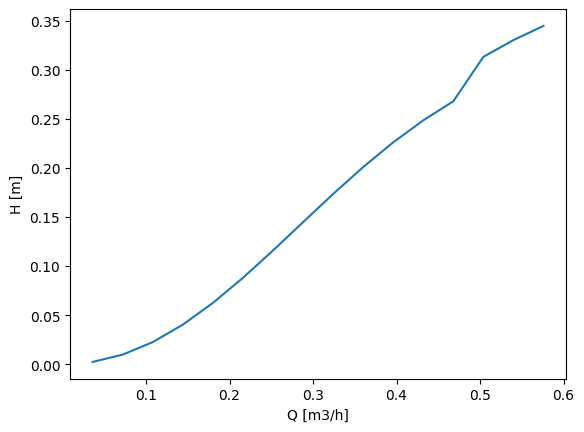

In [45]:
#for loop with 
H =[] # list to store head losses 
Q_test = np.arange(0.00001, 0.00016 + 0.00001, 0.00001).tolist() 

for Q in Q_test:
    H.append(network_head_losses(90.5, 45, 45, 4, 80, Q))

Q_test = [i * 3600 for i in Q_test] #m3/h
#add static head 
#H_static = 

plt.plot(Q_test, H)
plt.xlabel('Q [m3/h]')
plt.ylabel('H [m]')